In [361]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from itertools import cycle, islice

from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, f1_score
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


In [2]:
df = pd.read_csv('customerGroups.csv')

# 0. Exploratory Data Analysis

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6620 entries, 0 to 6619
Data columns (total 71 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   g1_1    6620 non-null   float64
 1   g1_2    6620 non-null   int64  
 2   g1_3    6620 non-null   int64  
 3   g1_4    6620 non-null   int64  
 4   g1_5    6620 non-null   int64  
 5   g1_6    6620 non-null   int64  
 6   g1_7    6620 non-null   int64  
 7   g1_8    6620 non-null   int64  
 8   g1_9    6620 non-null   int64  
 9   g1_10   6620 non-null   int64  
 10  g1_11   6620 non-null   int64  
 11  g1_12   6620 non-null   int64  
 12  g1_13   6620 non-null   float64
 13  g1_14   6620 non-null   float64
 14  g1_15   6620 non-null   float64
 15  g1_16   6620 non-null   float64
 16  g1_17   6620 non-null   float64
 17  g1_18   6620 non-null   float64
 18  g1_19   6620 non-null   float64
 19  g1_20   6620 non-null   float64
 20  g1_21   6620 non-null   float64
 21  g2_1    6620 non-null   float64
 22  

In [4]:
df.describe()

,g1_1,g1_2,g1_3,g1_4,g1_5,g1_6,g1_7,g1_8,g1_9,g1_10,...,c_20,c_21,c_22,c_23,c_24,c_25,c_26,c_27,c_28,target
count,6620.000000,6620.000000,6620.000000,6620.000000,6620.000000,6620.000000,6620.000000,6620.000000,6620.000000,6620.000000,...,6620.000000,6620.000000,6620.000000,6620.000000,6620.00000,6620.000000,6620.000000,6620.000000,6620.000000,6620.000000
mean,2.708779,14.424018,10.485650,24.909668,10.988066,13.412085,10.161027,10.745468,14.169033,3.251057,...,-0.029311,-0.006724,-0.004147,0.008827,0.00000,-0.228426,-0.103728,0.000408,1.917134,1.031722
std,1.857725,10.700787,8.384203,18.174948,5.635985,10.090030,7.495039,7.964247,9.866734,8.481210,...,1.220752,1.068199,0.663238,0.683422,0.32287,3.390902,1.944419,0.092761,0.302175,0.731042
min,1.050000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,-27.000000,...,-4.684111,-4.319826,-2.512919,-3.118836,-2.00000,-15.202740,-9.181722,-0.750000,0.000000,0.000000
25%,1.667000,6.000000,4.000000,10.000000,6.000000,5.000000,4.000000,4.000000,6.000000,-2.000000,...,-0.716407,-0.531224,-0.440407,-0.406811,0.00000,-2.222226,-1.293471,-0.054331,1.710000,0.000000
50%,2.150000,13.000000,9.000000,22.000000,11.000000,12.000000,9.000000,9.000000,13.000000,1.000000,...,0.000000,0.000000,0.000000,0.001070,0.00000,-0.119378,-0.012487,0.000000,1.850000,1.000000
75%,2.800000,21.000000,15.000000,36.000000,16.000000,20.000000,15.000000,16.000000,21.000000,7.000000,...,0.654627,0.490504,0.410915,0.450104,0.00000,1.809334,1.035235,0.054825,2.020000,2.000000
max,23.000000,52.000000,47.000000,94.000000,20.000000,61.000000,43.000000,48.000000,52.000000,48.000000,...,4.821136,4.396281,2.987136,2.830550,2.00000,12.562698,8.209578,0.666667,4.330000,2.000000


In [5]:
pd.set_option('display.max_columns', None)

In [6]:
df.head()

,g1_1,g1_2,g1_3,g1_4,g1_5,g1_6,g1_7,g1_8,g1_9,g1_10,g1_11,g1_12,g1_13,g1_14,g1_15,g1_16,g1_17,g1_18,g1_19,g1_20,g1_21,g2_1,g2_2,g2_3,g2_4,g2_5,g2_6,g2_7,g2_8,g2_9,g2_10,g2_11,g2_12,g2_13,g2_14,g2_15,g2_16,g2_17,g2_18,g2_19,g2_20,g2_21,c_1,c_2,c_3,c_4,c_5,c_6,c_7,c_8,c_9,c_10,c_11,c_12,c_13,c_14,c_15,c_16,c_17,c_18,c_19,c_20,c_21,c_22,c_23,c_24,c_25,c_26,c_27,c_28,target
0,4.50,1,3,4,5,1,1,4,6,0,-2,-2,2.505032,2.551406,6.240000,3.608000,0.744000,1.216000,0.003078,0.003028,0.578205,1.83,6,0,6,7,4,0,0,1,4,-1,3,2.888736,2.616855,5.552000,0.728000,0.160000,0.002994,0.002953,0.586149,3.50,1.97,-1,7,6,0,0,0,1,3.223605,1,-3,-2,0,1,4,2,1,-6,-5,-0.383704,-0.065449,0.584000,0.488000,0,-3.232000,-1.944000,-0.007944,1.76,2
1,2.20,24,22,46,10,24,28,18,22,-4,-4,-8,3.718983,3.882271,7.423435,5.048030,0.836178,1.975244,0.784882,0.019448,0.680013,2.80,34,14,48,10,25,16,16,24,9,-8,1,4.065822,4.042015,6.369385,1.511704,1.783791,0.784882,0.033373,0.498949,3.25,1.85,2,1,3,0,0,0,0,1.541039,10,-12,-2,0,12,2,-3,4,-13,-9,-0.346839,-0.159744,-0.947614,0.463540,0,-5.342174,-1.321355,0.181064,1.85,1
2,12.00,7,4,11,18,8,11,2,10,-3,-8,-11,2.244550,2.458087,11.091399,5.853005,0.730046,2.022004,0.043937,0.014264,0.527707,1.30,11,18,29,2,13,3,16,1,10,15,25,4.918483,4.050389,10.029408,2.489174,0.204741,0.022247,0.042004,0.567984,5.00,1.70,-5,10,5,0,0,0,1,2.049024,-11,-7,-18,7,-5,-1,-3,-18,-18,-36,-2.673934,-1.592303,0.525305,-0.467169,0,-6.566521,-4.176403,-0.040277,2.05,2
3,1.91,8,5,13,14,6,7,6,9,-1,-3,-4,2.580190,2.683092,9.864426,2.582357,0.656638,1.407549,0.041563,0.021386,0.261785,4.50,5,3,8,17,5,9,7,16,-4,-9,-13,1.964163,2.278147,3.369489,0.665585,2.163561,0.043937,0.010358,0.273886,3.60,1.98,-1,3,2,0,0,0,0,2.284503,5,0,5,-10,0,-3,4,8,1,9,0.616027,0.404945,-1.506923,0.741964,0,-2.438120,-0.787132,-0.012101,1.82,0
4,2.50,23,16,39,14,33,25,18,27,8,-9,-1,3.470617,3.055989,11.672962,4.554560,1.895740,1.237122,0.941241,0.000062,0.390180,3.00,29,23,52,8,31,22,21,23,9,-2,7,4.527831,4.215284,4.494986,1.419174,1.144728,0.364776,0.008148,0.347568,3.40,1.80,-3,2,-1,1,0,0,0,2.648418,0,-13,-13,10,4,-4,-4,10,-18,-8,-1.057214,-1.159294,0.751012,-0.182052,0,-1.259728,0.059574,0.042613,1.99,2


In [7]:
df.isna().sum().sum() # check for null values

0

In [8]:
df['target'].unique() # check for errors if target have only described categories

array([2, 1, 0], dtype=int64)

In [9]:
df.columns

Index(['g1_1', 'g1_2', 'g1_3', 'g1_4', 'g1_5', 'g1_6', 'g1_7', 'g1_8', 'g1_9',
       'g1_10', 'g1_11', 'g1_12', 'g1_13', 'g1_14', 'g1_15', 'g1_16', 'g1_17',
       'g1_18', 'g1_19', 'g1_20', 'g1_21', 'g2_1', 'g2_2', 'g2_3', 'g2_4',
       'g2_5', 'g2_6', 'g2_7', 'g2_8', 'g2_9', 'g2_10', 'g2_11', 'g2_12',
       'g2_13', 'g2_14', 'g2_15', 'g2_16', 'g2_17', 'g2_18', 'g2_19', 'g2_20',
       'g2_21', 'c_1', 'c_2', 'c_3', 'c_4', 'c_5', 'c_6', 'c_7', 'c_8', 'c_9',
       'c_10', 'c_11', 'c_12', 'c_13', 'c_14', 'c_15', 'c_16', 'c_17', 'c_18',
       'c_19', 'c_20', 'c_21', 'c_22', 'c_23', 'c_24', 'c_25', 'c_26', 'c_27',
       'c_28', 'target'],
      dtype='object')

In [10]:
# changing type of columns to same float64 (int64 -> float64)
#       except for target column
for i in df:
    if i != 'target':
        if df[i].dtype == 'int64':
            df[i] = df[i].astype('float64')
    else:
        df[i] = df[i].astype('category')

In [363]:
#df.info()

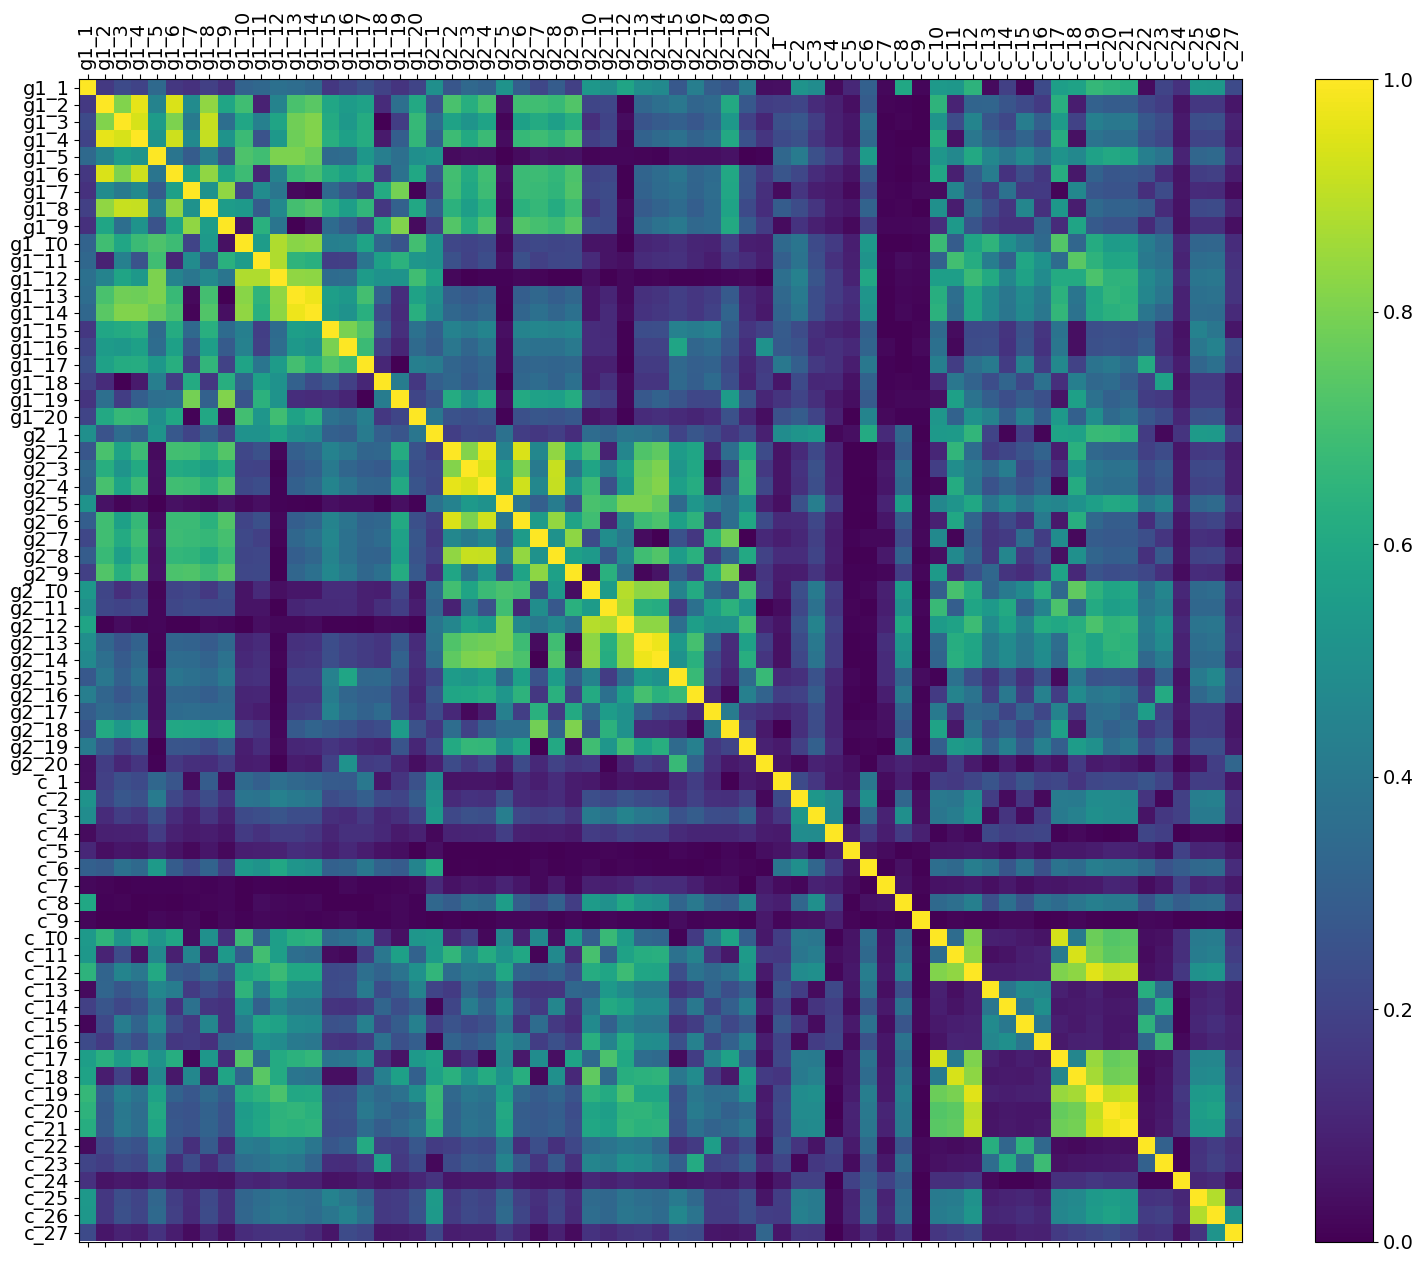

In [364]:
corr = df.corr()
f = plt.figure(figsize=(19, 15))
plt.matshow(corr.abs(), fignum=f.number)
plt.xticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14, rotation=90)
plt.yticks(range(df.select_dtypes(['number']).shape[1]), df.select_dtypes(['number']).columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.show(f)

# Q1.  What percentage of campaigns led to group 1 being the most profitable? What about group 2? And neither of the groups?

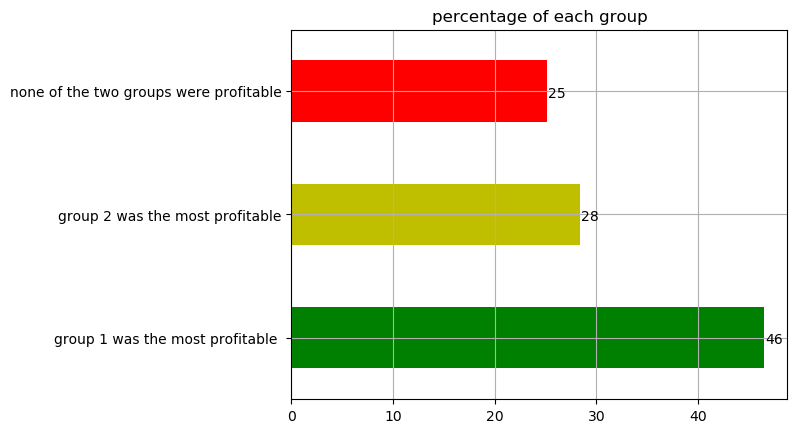

In [14]:

target_vis = df.target.value_counts(normalize=True)*100
target_vis = target_vis.rename({0: 'none of the two groups were profitable', 1: 'group 1 was the most profitable ', 2: 'group 2 was the most profitable'})
my_colors = list(islice(cycle(['g', 'y', 'r']), None, len(df)))
ax = target_vis.plot.barh(title='percentage of each group', grid = True, color = my_colors)
for p in ax.patches:
    ax.annotate(str(int(p.get_width())), (p.get_width() + 0.1, p.get_y() + 0.2,))


# Q2.  Based on all the information you have, can you build a model to optimize future campaigns? Given the characteristics of two different groups of customers, please predict which group to target

In [15]:
df = df.drop(['g1_21', 'g2_21', 'c_28'], axis = 1, errors='ignore')
Y = df['target']
X = df.drop(['target'],axis=1)

### normalization

In [16]:
trans = MinMaxScaler()
X_trans = trans.fit_transform(X)
X_train, X_test,y_train,y_test = train_test_split(X_trans, Y, test_size = 0.25)

In [19]:
def model_tester(model ,X_tr, y_tr, X_te, conf_matrix, **func_args):
    model = model(**func_args)
    model.fit(X_tr, y_tr)

    y_pred = model.predict(X_te)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')

    if conf_matrix == True:
        print("Accuracy:", accuracy)
        cm = confusion_matrix(y_test, y_pred)
        ConfusionMatrixDisplay(confusion_matrix=cm).plot()
    else:
        print("Accuracy:", accuracy)
    
    return str(model), accuracy, precision, recall, f1

In [353]:
def model_tester2(model_name ,X_tr, y_tr, X_te, conf_matrix, func_args):
    if len(func_args) != 0:
        model = model_name(**func_args)
    else:
        model = model_name()
    model.fit(X_tr, y_tr)

    y_pred = model.predict(X_te)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')


    if conf_matrix == True:
        print("Accuracy:", accuracy)
        cm = confusion_matrix(y_test, y_pred)
        ConfusionMatrixDisplay(confusion_matrix=cm).plot()
    else:
        pass

    return str(model_name), accuracy, precision, recall, f1

### Feature selection (numeric input, categorical output)

In [300]:
### Feature Selection (numeric input, categorical output)
def top_x_by_fclassif(x):
	fs = SelectKBest(score_func=f_classif, k=x)
	fs.fit(X_train, y_train)
	X_train_fs = fs.transform(X_train)
	X_test_fs = fs.transform(X_test)
	return fs, X_train_fs, X_test_fs

fs, X_train_fs, X_test_fs = top_x_by_fclassif(15)


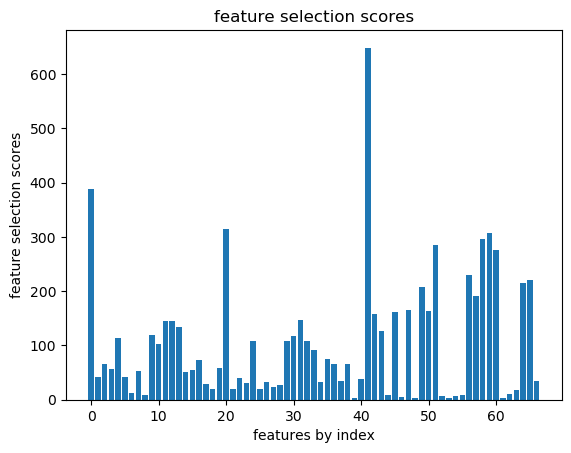

In [345]:
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.title('feature selection scores')
plt.xlabel('features by index')
plt.ylabel('feature selection scores')
plt.show()

c:\Users\krukd\.conda\envs\payback_challenge\lib\site-packages\ipykernel_launcher.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  """


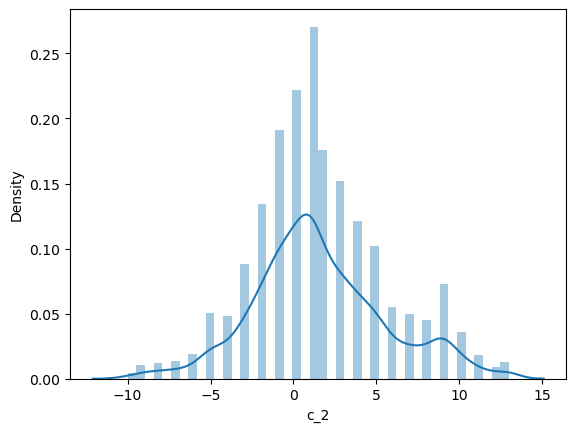

In [346]:
arr = np.amax(fs.scores_)
result = np.where(fs.scores_ == arr)
best_feature = X.columns[result[0][0]]

sns.distplot(df[best_feature])

In [221]:
models_dict = {LogisticRegression : {}, RandomForestClassifier : {}, SVC : {'C': 1.0, 'kernel': "linear"},  GaussianNB: {}, GradientBoostingClassifier : {},  XGBClassifier : {}, LGBMClassifier: {}, CatBoostClassifier : {'verbose':0}}

In [167]:
# selecting x features to test model on

#fs_25, X_train_fs_25, X_test_fs_25 = top_x_by_fclassif(25)
#fs_20, X_train_fs_20, X_test_fs_20 = top_x_by_fclassif(20)
fs_15, X_train_fs_15, X_test_fs_15 = top_x_by_fclassif(15)
#fs_10, X_train_fs_10, X_test_fs_10 = top_x_by_fclassif(10)
#fs_5, X_train_fs_5, X_test_fs_5 = top_x_by_fclassif(5)
fs_3, X_train_fs_3, X_test_fs_3 = top_x_by_fclassif(3)
fs_train_list = [X_train, X_train_fs_15, X_train_fs_3]
fs_test_list = [X_test, X_test_fs_15, X_test_fs_3]


testing different algorithms with different number of fearures

In [222]:
%%capture
models_metrics = {}
for model, model_args in models_dict.items():
    for X_train_fs, X_test_fs in zip(fs_train_list, fs_test_list):
        name, accuracy, precision, recall, f1 = model_tester2(model, X_train_fs, y_train, X_test_fs, False, model_args);
        
        models_metrics[str(model).split("'")[1].split(".")[-1] + ' with ' + str(X_train_fs.shape[1]) + ' features'] = [accuracy, precision, recall, f1];

In [117]:
models_metrics_df = pd.DataFrame.from_dict(models_metrics, orient='index', columns=[ 'accuracy', 'precision', 'recall', 'f1'])
models_metrics_df.style.highlight_max(color = 'green', axis = 0)

,accuracy,precision,recall,f1
LogisticRegression with 67 features,0.581269,0.510740,0.581269,0.519560
LogisticRegression with 15 features,0.583082,0.524466,0.583082,0.503421
LogisticRegression with 3 features,0.583686,0.446499,0.583686,0.503139
RandomForestClassifier with 67 features,0.578852,0.527509,0.578852,0.539015
RandomForestClassifier with 15 features,0.578248,0.541316,0.578248,0.550405
RandomForestClassifier with 3 features,0.517221,0.511383,0.517221,0.513337
SVC with 67 features,0.580665,0.522334,0.580665,0.513318
SVC with 15 features,0.573414,0.502564,0.573414,0.503188
SVC with 3 features,0.586103,0.448256,0.586103,0.505018
GaussianNB with 67 features,0.485196,0.533409,0.485196,0.501210


testing different algorithms with different number of fearures with use of cross validation

In [118]:
%%capture
models_metrics = {}
for model, model_args in models_dict.items():
    for X_train_fs, X_test_fs in zip(fs_train_list, fs_test_list):

        cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
        n_scores = cross_val_score(model(), X_train_fs, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')

        models_metrics[str(model).split("'")[1].split(".")[-1] + str(X_train_fs.shape[1])] = ['%.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores))]#, accuracy, precision, recall, f1];

In [119]:
models_metrics_df = pd.DataFrame.from_dict(models_metrics, orient='index', columns=['accuracy (std)'])#, 'accuracy', 'precision', 'recall', 'f1'])
models_metrics_df.style.highlight_max(color = 'green', axis = 0)

,accuracy (std)
LogisticRegression67,0.572 (0.017)
LogisticRegression15,0.574 (0.014)
LogisticRegression3,0.581 (0.013)
RandomForestClassifier67,0.568 (0.018)
RandomForestClassifier15,0.560 (0.018)
RandomForestClassifier3,0.492 (0.017)
SVC67,0.563 (0.015)
SVC15,0.569 (0.016)
SVC3,0.581 (0.014)
GaussianNB67,0.489 (0.025)


fine tuning best algorithms

In [369]:
GBC_tuning_lr = {GradientBoostingClassifier : [{'learning_rate': 0.01}, {'learning_rate': 0.2}, {'learning_rate': 0.5}, {'learning_rate': 1}]}
GBC_tuning_n_est = {GradientBoostingClassifier : [{'n_estimators': 1}, {'n_estimators': 5}, {'n_estimators': 25}, {'n_estimators': 35}, {'n_estimators': 50}, {'n_estimators': 65}, {'n_estimators': 100}]}
GBC_tuning_max_depth = {GradientBoostingClassifier : [{'max_depth': 1}, {'max_depth': 5}, {'max_depth': 15}]}
GBC_tuning_min_samples_split = {GradientBoostingClassifier : [{'min_samples_split': 0.1}, {'min_samples_split': 0.3}, {'min_samples_split': 1.}]}
GBC_tuning_min_samples_leafs = {GradientBoostingClassifier : [{'min_samples_leaf': 0.1}, {'min_samples_leaf': 0.2}, {'min_samples_leaf': 0.5}]}
GBC_tuning_max_features = {GradientBoostingClassifier : [{'max_features': 1}, {'max_features': 3}, {'max_features': 10}]}

In [354]:
def model_tuning(model_tuning, fs_train_list, fs_test_list):
    model_metrics = {}
    for model, model_args_list in model_tuning.items():
        for model_args in model_args_list:
            print(model, model_args)
            for X_train_fs, X_test_fs in zip(fs_train_list, fs_test_list):
                name, accuracy, precision, recall, f1 = model_tester2(model, X_train_fs, y_train, X_test_fs, False, model_args);
                
                model_metrics[str(model).split("'")[1].split(".")[-1] + ' with ' + str(X_train_fs.shape[1]) + ' features and model args like ' + str(model_args)] = [accuracy, precision, recall, f1];
    return model_metrics

In [355]:
GBC_model_metrics = model_tuning(GBC_tuning_lr, fs_train_list, fs_test_list)
GBC_model_metrics_df = pd.DataFrame.from_dict(GBC_model_metrics, orient='index', columns=[ 'accuracy', 'precision', 'recall', 'f1'])
GBC_model_metrics_df.style.highlight_max(color = 'green', axis = 0)

<class 'sklearn.ensemble._gb.GradientBoostingClassifier'> {'learning_rate': 0.01}
<class 'sklearn.ensemble._gb.GradientBoostingClassifier'> {'learning_rate': 0.2}
<class 'sklearn.ensemble._gb.GradientBoostingClassifier'> {'learning_rate': 0.5}
<class 'sklearn.ensemble._gb.GradientBoostingClassifier'> {'learning_rate': 1}


,accuracy,precision,recall,f1
GradientBoostingClassifier with 67 features and model args like {'learning_rate': 0.01},0.597583,0.597604,0.597583,0.528566
GradientBoostingClassifier with 15 features and model args like {'learning_rate': 0.01},0.592749,0.518859,0.592749,0.515016
GradientBoostingClassifier with 3 features and model args like {'learning_rate': 0.01},0.594562,0.572605,0.594562,0.525446
GradientBoostingClassifier with 67 features and model args like {'learning_rate': 0.2},0.601813,0.567946,0.601813,0.570636
GradientBoostingClassifier with 15 features and model args like {'learning_rate': 0.2},0.598187,0.565362,0.598187,0.566724
GradientBoostingClassifier with 3 features and model args like {'learning_rate': 0.2},0.597583,0.563956,0.597583,0.565565
GradientBoostingClassifier with 67 features and model args like {'learning_rate': 0.5},0.548640,0.524646,0.548640,0.533228
GradientBoostingClassifier with 15 features and model args like {'learning_rate': 0.5},0.543202,0.514871,0.543202,0.524498
GradientBoostingClassifier with 3 features and model args like {'learning_rate': 0.5},0.574622,0.542652,0.574622,0.550003
GradientBoostingClassifier with 67 features and model args like {'learning_rate': 1},0.524471,0.516220,0.524471,0.518150


In [370]:
GBC_model_metrics = model_tuning(GBC_tuning_n_est, fs_train_list, fs_test_list)
GBC_model_metrics_df = pd.DataFrame.from_dict(GBC_model_metrics, orient='index', columns=[ 'accuracy', 'precision', 'recall', 'f1'])
GBC_model_metrics_df.style.highlight_max(color = 'green', axis = 0)

<class 'sklearn.ensemble._gb.GradientBoostingClassifier'> {'n_estimators': 1}


c:\Users\krukd\.conda\envs\payback_challenge\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\krukd\.conda\envs\payback_challenge\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\krukd\.conda\envs\payback_challenge\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<class 'sklearn.ensemble._gb.GradientBoostingClassifier'> {'n_estimators': 5}


c:\Users\krukd\.conda\envs\payback_challenge\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<class 'sklearn.ensemble._gb.GradientBoostingClassifier'> {'n_estimators': 25}
<class 'sklearn.ensemble._gb.GradientBoostingClassifier'> {'n_estimators': 35}
<class 'sklearn.ensemble._gb.GradientBoostingClassifier'> {'n_estimators': 50}
<class 'sklearn.ensemble._gb.GradientBoostingClassifier'> {'n_estimators': 65}
<class 'sklearn.ensemble._gb.GradientBoostingClassifier'> {'n_estimators': 100}


,accuracy,precision,recall,f1
GradientBoostingClassifier with 67 features and model args like {'n_estimators': 1},0.462840,0.214221,0.462840,0.292883
GradientBoostingClassifier with 15 features and model args like {'n_estimators': 1},0.462840,0.214221,0.462840,0.292883
GradientBoostingClassifier with 3 features and model args like {'n_estimators': 1},0.462840,0.214221,0.462840,0.292883
GradientBoostingClassifier with 67 features and model args like {'n_estimators': 5},0.574018,0.682449,0.574018,0.489604
GradientBoostingClassifier with 15 features and model args like {'n_estimators': 5},0.580665,0.449818,0.580665,0.497122
GradientBoostingClassifier with 3 features and model args like {'n_estimators': 5},0.586707,0.450110,0.586707,0.504541
GradientBoostingClassifier with 67 features and model args like {'n_estimators': 25},0.610876,0.582851,0.610876,0.572676
GradientBoostingClassifier with 15 features and model args like {'n_estimators': 25},0.605438,0.572651,0.605438,0.568573
GradientBoostingClassifier with 3 features and model args like {'n_estimators': 25},0.606042,0.577538,0.606042,0.570475
GradientBoostingClassifier with 67 features and model args like {'n_estimators': 35},0.610876,0.583002,0.610876,0.573187


In [357]:
GBC_model_metrics = model_tuning(GBC_tuning_max_depth, fs_train_list, fs_test_list)
GBC_model_metrics_df = pd.DataFrame.from_dict(GBC_model_metrics, orient='index', columns=[ 'accuracy', 'precision', 'recall', 'f1'])
GBC_model_metrics_df.style.highlight_max(color = 'green', axis = 0)

<class 'sklearn.ensemble._gb.GradientBoostingClassifier'> {'max_depth': 1}
<class 'sklearn.ensemble._gb.GradientBoostingClassifier'> {'max_depth': 5}
<class 'sklearn.ensemble._gb.GradientBoostingClassifier'> {'max_depth': 15}


,accuracy,precision,recall,f1
GradientBoostingClassifier with 67 features and model args like {'max_depth': 1},0.610876,0.586355,0.610876,0.574267
GradientBoostingClassifier with 15 features and model args like {'max_depth': 1},0.606042,0.575091,0.606042,0.571703
GradientBoostingClassifier with 3 features and model args like {'max_depth': 1},0.607855,0.577495,0.607855,0.573294
GradientBoostingClassifier with 67 features and model args like {'max_depth': 5},0.583082,0.545710,0.583082,0.553794
GradientBoostingClassifier with 15 features and model args like {'max_depth': 5},0.587311,0.554859,0.587311,0.558559
GradientBoostingClassifier with 3 features and model args like {'max_depth': 5},0.590332,0.557947,0.590332,0.561468
GradientBoostingClassifier with 67 features and model args like {'max_depth': 15},0.568580,0.539817,0.568580,0.546823
GradientBoostingClassifier with 15 features and model args like {'max_depth': 15},0.551057,0.526764,0.551057,0.534649
GradientBoostingClassifier with 3 features and model args like {'max_depth': 15},0.514804,0.506381,0.514804,0.509535


In [358]:
GBC_model_metrics = model_tuning(GBC_tuning_min_samples_split, fs_train_list, fs_test_list)
GBC_model_metrics_df = pd.DataFrame.from_dict(GBC_model_metrics, orient='index', columns=[ 'accuracy', 'precision', 'recall', 'f1'])
GBC_model_metrics_df.style.highlight_max(color = 'green', axis = 0)

<class 'sklearn.ensemble._gb.GradientBoostingClassifier'> {'min_samples_split': 0.1}
<class 'sklearn.ensemble._gb.GradientBoostingClassifier'> {'min_samples_split': 0.3}
<class 'sklearn.ensemble._gb.GradientBoostingClassifier'> {'min_samples_split': 1.0}


,accuracy,precision,recall,f1
GradientBoostingClassifier with 67 features and model args like {'min_samples_split': 0.1},0.604230,0.571261,0.604230,0.567817
GradientBoostingClassifier with 15 features and model args like {'min_samples_split': 0.1},0.598792,0.561153,0.598792,0.561881
GradientBoostingClassifier with 3 features and model args like {'min_samples_split': 0.1},0.607855,0.578148,0.607855,0.572301
GradientBoostingClassifier with 67 features and model args like {'min_samples_split': 0.3},0.600604,0.566695,0.600604,0.561610
GradientBoostingClassifier with 15 features and model args like {'min_samples_split': 0.3},0.604230,0.573546,0.604230,0.568928
GradientBoostingClassifier with 3 features and model args like {'min_samples_split': 0.3},0.606647,0.575799,0.606647,0.571393
GradientBoostingClassifier with 67 features and model args like {'min_samples_split': 1.0},0.610876,0.586355,0.610876,0.574267
GradientBoostingClassifier with 15 features and model args like {'min_samples_split': 1.0},0.606042,0.575091,0.606042,0.571703
GradientBoostingClassifier with 3 features and model args like {'min_samples_split': 1.0},0.607855,0.577495,0.607855,0.573294


In [359]:
GBC_model_metrics = model_tuning(GBC_tuning_min_samples_leafs, fs_train_list, fs_test_list)
GBC_model_metrics_df = pd.DataFrame.from_dict(GBC_model_metrics, orient='index', columns=[ 'accuracy', 'precision', 'recall', 'f1'])
GBC_model_metrics_df.style.highlight_max(color = 'green', axis = 0)

<class 'sklearn.ensemble._gb.GradientBoostingClassifier'> {'min_samples_leaf': 0.1}
<class 'sklearn.ensemble._gb.GradientBoostingClassifier'> {'min_samples_leaf': 0.2}
<class 'sklearn.ensemble._gb.GradientBoostingClassifier'> {'min_samples_leaf': 0.5}


c:\Users\krukd\.conda\envs\payback_challenge\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\krukd\.conda\envs\payback_challenge\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\krukd\.conda\envs\payback_challenge\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,accuracy,precision,recall,f1
GradientBoostingClassifier with 67 features and model args like {'min_samples_leaf': 0.1},0.600604,0.564900,0.600604,0.560196
GradientBoostingClassifier with 15 features and model args like {'min_samples_leaf': 0.1},0.601208,0.569255,0.601208,0.565015
GradientBoostingClassifier with 3 features and model args like {'min_samples_leaf': 0.1},0.601813,0.569201,0.601813,0.561828
GradientBoostingClassifier with 67 features and model args like {'min_samples_leaf': 0.2},0.598792,0.562790,0.598792,0.559064
GradientBoostingClassifier with 15 features and model args like {'min_samples_leaf': 0.2},0.606042,0.575101,0.606042,0.565641
GradientBoostingClassifier with 3 features and model args like {'min_samples_leaf': 0.2},0.607855,0.580447,0.607855,0.570773
GradientBoostingClassifier with 67 features and model args like {'min_samples_leaf': 0.5},0.462840,0.214221,0.462840,0.292883
GradientBoostingClassifier with 15 features and model args like {'min_samples_leaf': 0.5},0.462840,0.214221,0.462840,0.292883
GradientBoostingClassifier with 3 features and model args like {'min_samples_leaf': 0.5},0.462840,0.214221,0.462840,0.292883


In [365]:
GBC_model_metrics = model_tuning(GBC_tuning_max_features, fs_train_list[0:1], fs_test_list[0:1])
GBC_model_metrics_df = pd.DataFrame.from_dict(GBC_model_metrics, orient='index', columns=[ 'accuracy', 'precision', 'recall', 'f1'])
GBC_model_metrics_df.style.highlight_max(color = 'green', axis = 0)

<class 'sklearn.ensemble._gb.GradientBoostingClassifier'> {'max_features': 1}
<class 'sklearn.ensemble._gb.GradientBoostingClassifier'> {'max_features': 3}
<class 'sklearn.ensemble._gb.GradientBoostingClassifier'> {'max_features': 10}


,accuracy,precision,recall,f1
GradientBoostingClassifier with 67 features and model args like {'max_features': 1},0.569184,0.517762,0.569184,0.504658
GradientBoostingClassifier with 67 features and model args like {'max_features': 3},0.592145,0.554595,0.592145,0.546430
GradientBoostingClassifier with 67 features and model args like {'max_features': 10},0.597583,0.561256,0.597583,0.560221


In [382]:
#training best model
model = GradientBoostingClassifier(learning_rate=0.1, n_estimators=50, max_depth=3, min_samples_split=2, min_samples_leaf=1)
model.fit(X_train, y_train)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
n_scores = cross_val_score(GradientBoostingClassifier(), X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
model_metrics = {'GradientBoostingClassifier(learning_rate=0.1, n_estimators=50, max_depth=3, min_samples_split=2, min_samples_leaf=1)' : ['%.3f (%.3f)' % (np.mean(n_scores), np.std(n_scores)), accuracy, precision, recall, f1]}

model_metrics_df = pd.DataFrame.from_dict(model_metrics, orient='index', columns=['accuracy (std)', 'accuracy', 'precision', 'recall', 'f1'])
model_metrics_df.style.highlight_max(color = 'green', axis = 0)

,accuracy (std),accuracy,precision,recall,f1
"GradientBoostingClassifier(learning_rate=0.1, n_estimators=50, max_depth=3, min_samples_split=2, min_samples_leaf=1)",0.582 (0.021),0.613293,0.587272,0.613293,0.576150


The output of the model makes it possible to predict which group is worth investing in. 

* 0: none of the two groups are worth investing in 
* 1: group 1 is the most worth investing in
* 2: group 2 is the most worth investing in

# Q3.  By how much do you think your model could improve campaign success rates? How would you test that?

We can set a benchmark of accuracy of coin flip classifier, because our dataset is imbalanced we can calculate it like this: 

In [85]:
(df.target.value_counts(normalize=True)**2).sum()

0.3597035897810352

So model could improve campaign success rates by around 25%

Additionally, it's worth considering the specific business context and objectives. A higher accuracy or other metric may not necessarily correspond to a direct improvement in campaign success rates if other factors like costs, conversion rates, or other business considerations are involved.

Therefore, it's essential to evaluate the performance of best classifier comprehensively, considering multiple metrics and conducting appropriate business analysis to assess its potential impact on campaign success rates.

In order to accurately test that, I would have to have more information about featueres that were presented to me. 

# Q4.  Optional: Can you write an API for your model that the marketing IT team can call?

In [383]:
# creating .pkl file with best model in it
pickle.dump(model, open('best_model.pkl', 'wb'))

You can check model performance on https://blooming-scrubland-86405.herokuapp.com/

* By POSTing JSON in format :
* g1_1: float
    g1_2: float
    g1_3: float
    g1_4: float
    g1_5: float
    g1_6: float
    g1_7: float
    g1_8: float
    g1_9: float
    g1_10: float
    g1_11: float
    g1_12: float
    g1_13: float
    g1_14: float
    g1_15: float
    g1_16: float
    g1_17: float
    g1_18: float
    g1_19: float
    g1_20: float
    g2_1: float
    g2_2: float
    g2_3: float
    g2_4: float
    g2_5: float
    g2_6: float
    g2_7: float
    g2_8: float
    g2_9: float
    g2_10: float
    g2_11: float
    g2_12: float
    g2_13: float
    g2_14: float
    g2_15: float
    g2_16: float
    g2_17: float
    g2_18: float
    g2_19: float
    g2_20: float
    c_1: float
    c_2: float
    c_3: float
    c_4: float
    c_5: float
    c_6: float
    c_7: float
    c_8: float
    c_9: float
    c_10: float
    c_11: float
    c_12: float
    c_13: float
    c_14: float
    c_15: float
    c_16: float
    c_17: float
    c_18: float
    c_19: float
    c_20: float
    c_21: float
    c_22: float
    c_23: float
    c_24: float
    c_25: float
    c_26: float
    c_27: float

In [368]:
# creating example in json to post it on uvicorn app
example = X.iloc[0,:]
example.to_json(orient="index")

'{"g1_1":4.5,"g1_2":1.0,"g1_3":3.0,"g1_4":4.0,"g1_5":5.0,"g1_6":1.0,"g1_7":1.0,"g1_8":4.0,"g1_9":6.0,"g1_10":0.0,"g1_11":-2.0,"g1_12":-2.0,"g1_13":2.5050318819,"g1_14":2.5514063764,"g1_15":6.24,"g1_16":3.608,"g1_17":0.744,"g1_18":1.216,"g1_19":0.0030780093,"g1_20":0.0030275547,"g2_1":1.83,"g2_2":6.0,"g2_3":0.0,"g2_4":6.0,"g2_5":7.0,"g2_6":4.0,"g2_7":0.0,"g2_8":0.0,"g2_9":1.0,"g2_10":4.0,"g2_11":-1.0,"g2_12":3.0,"g2_13":2.8887363683,"g2_14":2.6168550926,"g2_15":5.552,"g2_16":0.728,"g2_17":0.16,"g2_18":0.0029936856,"g2_19":0.0029528042,"g2_20":0.5861486486,"c_1":1.97,"c_2":-1.0,"c_3":7.0,"c_4":6.0,"c_5":0.0,"c_6":0.0,"c_7":0.0,"c_8":1.0,"c_9":3.2236053804,"c_10":1.0,"c_11":-3.0,"c_12":-2.0,"c_13":0.0,"c_14":1.0,"c_15":4.0,"c_16":2.0,"c_17":1.0,"c_18":-6.0,"c_19":-5.0,"c_20":-0.3837044864,"c_21":-0.0654487162,"c_22":0.584,"c_23":0.488,"c_24":0.0,"c_25":-3.232,"c_26":-1.944,"c_27":-0.0079435204}'

I used postman to do so: 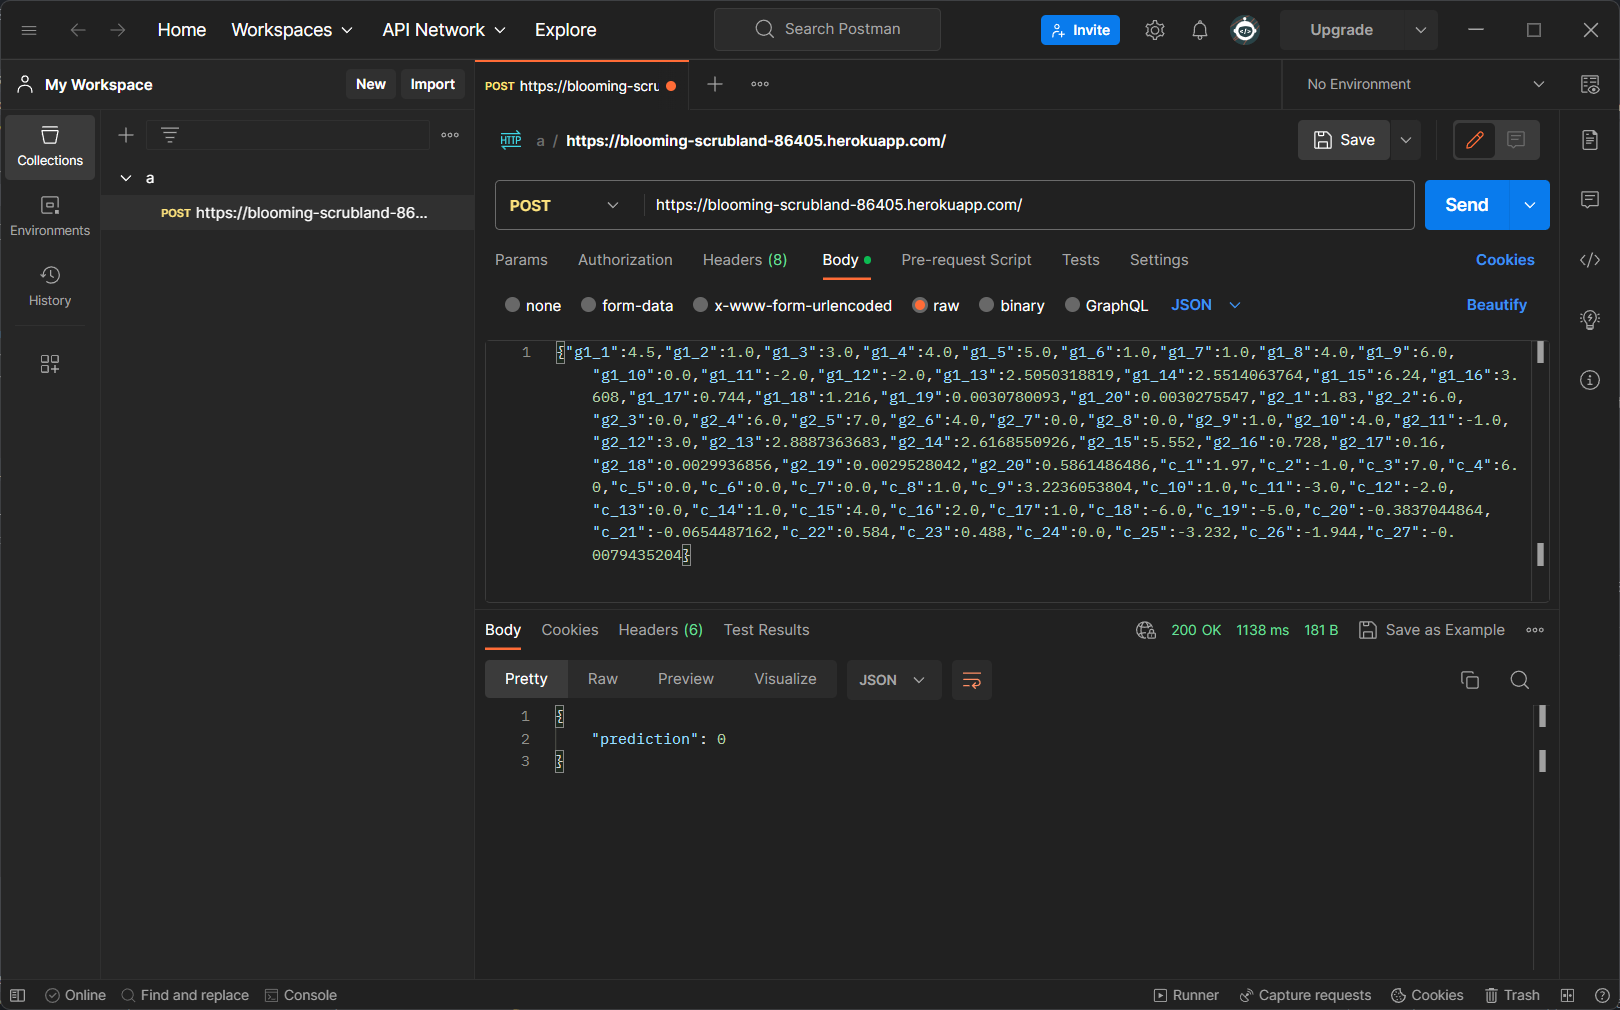

Results propobly could be better, if I could talk to the marteking team and learn more about the data.